In [1]:
% cd /home/mayu-ot/durga/Experiments/loc_iparaphrasing/

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


In [3]:
import pandas as pd
import tables
from chainercv.utils import bbox_iou
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display

In [13]:
def write_phrase_pair_wt_gtroi(split):
    base_df = pd.read_csv('data/phrase_pair_remove_trivial_match_%s.csv'% split)
    bbox_df = pd.read_csv('data/gt_roi_cord_%s.csv'% split)
    h5file = tables.open_file('data/region_feat/roi/full_%s.h5' % split)

    Lbbox = []

    fp = IntProgress(min=0, max=len(base_df))
    display(fp)

    img_id = None
    for i, row in base_df.iterrows():
        if img_id != str(row['image']):
            img_id = str(row['image'])
            rois = h5file.get_node('/', img_id).read()
            sub_df = bbox_df[bbox_df.image == row['image']]

        for phr in [row['phrase1'], row['phrase2']]:
            bboxs = sub_df[(bbox_df.phrase == phr)].loc[:, [ 'xmin', 'ymin', 'xmax', 'ymax']]
            bboxs = np.asarray(bboxs)
            bboxs = np.asarray([[bboxs[:,0].min(), bboxs[:, 1].min(), bboxs[:, 2].max(), bboxs[:, 3].max()]])
            ious = bbox_iou(rois, bboxs)
            ious = ious.ravel()
            gt_l = np.argmax(ious) if ious.max() > .5 else -1
            Lbbox.append(gt_l)

        fp.value = i

    bbox_label = np.asarray(Lbbox).reshape((-1, 2))
    base_df['roi1'] = bbox_label[:, 0].astype('i')
    base_df['roi2'] = bbox_label[:, 1].astype('i')
    base_df.to_csv('data/gt-roi/phrase_pair_%s.csv' % split)

In [14]:
write_phrase_pair_wt_gtroi('val')

IntProgress(value=0, max=80813)

/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
write_phrase_pair_wt_gtroi('train')
write_phrase_pair_wt_gtroi('test')

IntProgress(value=0, max=2383734)

/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


230 49 318 154


Text(0.5,1,'colorful+dress')

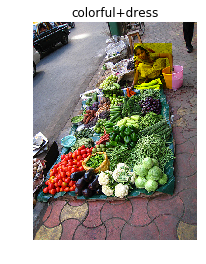

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import imageio

split ='val'
df = pd.read_csv('data/gt-roi/phrase_pair_%s.csv' % split)
h5file = tables.open_file('data/region_feat/roi/full_%s.h5' % split)

i = np.random.randint(len(df))

row = df.iloc[i]

img_id = row['image']
phr = row['phrase1']
bbox_i = row['roi1']

rois = h5file.get_node('/', str(img_id)).read()

im = imageio.imread('/home/mayu-ot/durga/Dataset/Flickr30kEntities/flickr30k-images/%i.jpg'%img_id)

if bbox_i >= 0:
    cord = rois[bbox_i]
    x_min, y_min, x_max, y_max = cord # numpy
    print(x_min, y_min, x_max, y_max)
    im[y_min:y_max, x_min:x_max, 2] = 0

plt.imshow(im)
plt.axis('off')
plt.title(phr)